In [425]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.table import Table

In [427]:
# Read the table
t1 = Table.read('TGAS200xWright4x2MASS.vot',format='votable')
print(t1.colnames)
Source = t1["Source"]
Gmags = t1["__Gmag_"]
Vmags = t1["VTmag"]
Jmags = t1["Jmag"]
Hmags = t1["Hmag"]
Kmags = t1["Kmag"]
QFlags = t1["Qfl"]
DistW = t1["Dist"]
d1 = t1["d_arcsec"]
d2 = t1["d_arcsec_2"]
print("Finished reading Table. Read ",len(Jmags)," sources")

['d_arcsec', 'd_arcsec_2', '_RAJ2000', '_DEJ2000', 'HIP', 'TYC2', 'Source', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Dup', '__FG_', 'e__FG_', '__Gmag_', 'Var', '_RAJ2000_2', '_DEJ2000_2', 'TYC1', 'TYC2_2', 'TYC3', 'RAJ2000', 'DEJ2000', 'VTmag', 'BTmag', 'r_SpType', 'Name', 'Dist', 'Mag', 'LClass', 'Teff', 'SpType', '_2MASS', 'RAJ2000_2', 'DEJ2000_2', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X', 'MeasureJD']
Finished reading Table. Read  75505  sources


First we will remove stars from the Wright catalog with Spectral matches that were further away from the Tycho/Hipp position by more than 4". To do this we will mask the relevant rows. This is a bit tricky as we use the name of each column to construct the variable name.mask.

In [428]:
for i in range(0,len(DistW)):
    if(DistW[i] > 4.0):
        row = t1[i]
        cols = row._table.columns.values()
        for col in cols:
            col.mask[i] = True
for i in range(0,len(DistW)):
    if(DistW[i] > 4.0):
        print(i,DistW[i])
print("Finished masking rows with >4 arcsec matches in Wright et al")
test = DistW.compressed()
print("   Remaining number of sources: ",len(test))

Finished masking rows with >4 arcsec matches in Wright et al
   Remaining number of sources:  75505


Use the Dup flag in the GAIA catalog to mask sources which have nearby neighbors in GAIA which complicated the measurements. Dup=0 is the good value.

In [429]:
GAIA_Dup = t1["Dup"]
for i in range(0,len(GAIA_Dup)):
    if(GAIA_Dup.mask[i] == False):
        if(GAIA_Dup[i] > 0.5):
            row = t1[i]
            cols = row._table.columns.values()
            for col in cols:
                col.mask[i] = True
print("Finished masking sources with GAIA Dup flag of 1 or greater")
test = GAIA_Dup.compressed()
print("   Remaining number of sources: ",len(test))

Finished masking sources with GAIA Dup flag of 1 or greater
   Remaining number of sources:  50162


Look at the number of duplicate matches --- places were one than 1 GAIA source matches with a 2MASS source or where 1 2MASS source matches with more than one GAIA source

In [430]:
Test = Source.compressed()
unique = set()
Gdups = set()

for i in range(0,len(Test)):
    if(Test[i] in unique):
        print("GAIA Duplicate Source: ",Test[i])
        Gdups.add(Test[i])
    else:
        unique.add(Test[i])
print("Finished GAIA Duplicate Check. Found: ", len(Gdups))

for i in range(0,len(Source)):
    if(Source.mask[i] == False):
        Name = Source[i]
        if(Name in Gdups):
            row = t1[i]
            cols = row._table.columns.values()
            for col in cols:
                col.mask[i] = True
print("Finished masking all GAIA duplicates. All sources involved")
TwoM = t1["_2MASS"]
unique = set()
Tdups = set()
Test = TwoM.compressed()
for i in range(0,len(Test)):
    if(Test[i] in unique):
        print("2MASS Duplicate Source: ",Test[i])
        Tdups.add(Test[i])
    else:
        unique.add(Test[i])
print("Finished 2MASS Duplicate Check. Found: ", len(Tdups))

for i in range(0,len(TwoM)):
    if(Source.mask[i] == False):
        Name = TwoM[i]
        if(Name in Tdups):
            row = t1[i]
            cols = row._table.columns.values()
            for col in cols:
                col.mask[i] = True
print("Finished masking all 2MASS duplicates. All sources involved")
Test = Source.compressed()
print("Remaining valid sources: ",len(Test))

GAIA Duplicate Source:  1512962359559680
GAIA Duplicate Source:  1414509064750524928
GAIA Duplicate Source:  6284251389929712128
GAIA Duplicate Source:  6652593488951220864
GAIA Duplicate Source:  350516782152418688
GAIA Duplicate Source:  3153870076878137600
GAIA Duplicate Source:  2389294498652881536
GAIA Duplicate Source:  5163910270279750272
GAIA Duplicate Source:  5447076227156166528
GAIA Duplicate Source:  2498832038900176000
GAIA Duplicate Source:  6726788842835559552
GAIA Duplicate Source:  6785793275342096256
GAIA Duplicate Source:  5769091159655753856
GAIA Duplicate Source:  3255252986058161408
GAIA Duplicate Source:  6790250970359184768
GAIA Duplicate Source:  2067478096721765376
GAIA Duplicate Source:  6655327390255709824
GAIA Duplicate Source:  11528207618987776
GAIA Duplicate Source:  6657758169946168576
GAIA Duplicate Source:  2398194667322958976
GAIA Duplicate Source:  5045205139519618816
GAIA Duplicate Source:  5133580860502607104
GAIA Duplicate Source:  60544936949835

Let's mask the 2MASS magnitudes that are really upper limites. We can do this using the Qfl value. It is a three letter code; one letter for each band: J, H,K. "A" is the best detection and "F is the worst. "U" means that there was no detection and the value is actually an upper limit. We will mask the J, H, K magnitude arrays according to the flags for each band with
D, E, F, and U masked.

Remember since I have done no arithematic with Jmags, Hmags, and Kmags, they are just pointers to the original table so I have actually masked the values in the table. If you were to pull out "Jmag" from the table again, it would now be flagged. The only way to go back to the original non-masked state is to read in the table again. I have done it this way on purpose.

In [431]:
# Use the 2MASS flags to mask the J, H, K magnitudes which are upper limits, or poor detections.
#   U = undetected, F, E, and D are poor detections

#for i in range(0,len(QFlags)):
#    if(QFlags[i][0] == ord("U")):
#        Jmags.mask[i] = True
#    if(QFlags[i][1] == ord("U")):
#        Hmags.mask[i] = True
#    if(QFlags[i][2] == ord("U")):
#        Kmags.mask[i] = True
#    if(QFlags[i][0] == ord("F")):
#        Jmags.mask[i] = True
#    if(QFlags[i][1] == ord("F")):
#        Hmags.mask[i] = True
#    if(QFlags[i][2] == ord("F")):
#        Kmags.mask[i] = True
#    if(QFlags[i][0] == ord("E")):
#        Jmags.mask[i] = True
#    if(QFlags[i][1] == ord("E")):
#        Hmags.mask[i] = True
#    if(QFlags[i][2] == ord("E")):
#        Kmags.mask[i] = True
#    if(QFlags[i][0] == ord("D")):
#        Jmags.mask[i] = True
#    if(QFlags[i][1] == ord("D")):
#        Hmags.mask[i] = True
#    if(QFlags[i][2] == ord("D")):
#        Kmags.mask[i] = True

# Or if you only want to keep the stars with "AAA" for their flags
for i in range(0,len(QFlags)):
    if(Source.mask[i] == False):
        if(QFlags[i][0] == ord("A")):
            Jmags.mask[i] = False
        else:
            Jmags.mask[i] = True
        if(QFlags[i][1] == ord("A")):
            Hmags.mask[i] = False
        else:
            Hmags.mask[i] = True
        if(QFlags[i][2] == ord("A")):
            Kmags.mask[i] = False
        else:
            Kmags.mask[i] = True
            
        if(Jmags[i] > 10.5):
            Jmags.mask[i] = True
        if(Hmags[i] > 10.5):
            Hmags.mask[i] = True
        if(Kmags[i] > 10.5):
            Kmags.mask[i] = True
            
print("Ended Flagging of 2MASS J, H, K magnitudes")


Ended Flagging of 2MASS J, H, K magnitudes


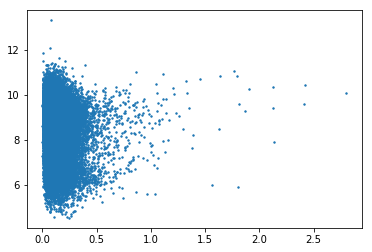

0.125526361692
0.0971624230702
Finished masking sources where the 2MASS - TGAS match was larger than 1.5
Remaining valid sources:  49975


In [432]:
plt.scatter(d1,Gmags,s=2.0)
plt.show()
print(np.mean(d1))
print(np.std(d1))
for i in range(0,len(d1)):
    if(Source.mask[i] == False):
        if(d1[i] > 1.5):
            row = t1[i]
            idx = row._index
            cols = row._table.columns.values()
            for col in cols:
                col.mask[i] = True
print("Finished masking sources where the 2MASS - TGAS match was larger than 1.5")
Test = Source.compressed()
print("Remaining valid sources: ",len(Test))

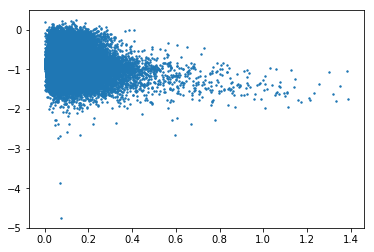

-0.862482618693
0.279739251502


In [433]:
JmG = Jmags - Gmags
plt.scatter(d1,JmG,s=2.0)
plt.show()
print(np.mean(JmG))
print(np.std(JmG))

We are going to use the mean J-G and 5 sigma to mask very large J-G values. These are either bad matches or extreme evolved stars which will not be useful for our analysis. These sources are entirely masked.

 Masked  17  rows based on J-G color > 5 sigma from mean


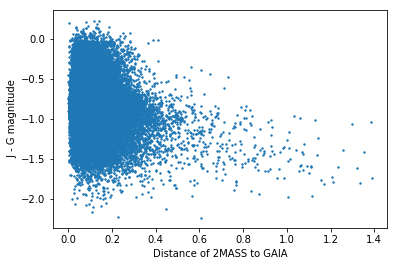

New sigma for J-G:  0.277471271959
Current number of valid Sources:  49958


In [434]:
imask = 0
for i in range(0,len(JmG)):
    if(abs(JmG[i] + 0.86) > 1.4):
        imask = imask + 1
        row = t1[i]
        idx = row._index
        cols = row._table.columns.values()
        for col in cols:
            col.mask[i] = True
print(" Masked ",imask," rows based on J-G color > 5 sigma from mean")
JmG = Jmags - Gmags
plt.xlabel("Distance of 2MASS to GAIA")
plt.ylabel(" J - G magnitude")
plt.scatter(d1,JmG,s=2.0)
plt.show()
print("New sigma for J-G: ",np.std(JmG))
Test = Source.compressed()
print("Current number of valid Sources: ",len(Test))

Now lets look a J, H, K magnitude-magnitude diagrams and the color-color diagram to see how much better they look with the upper limits all removed for plotting.

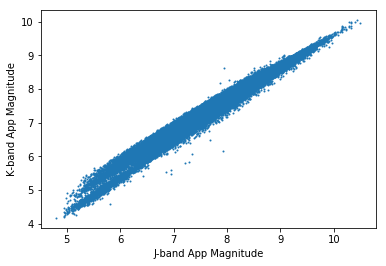

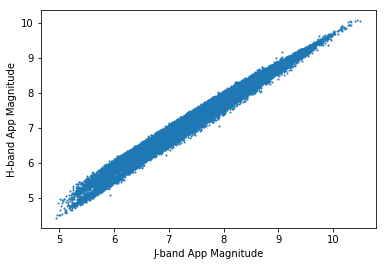

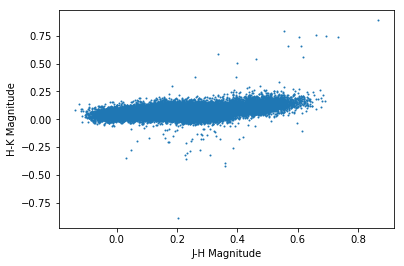

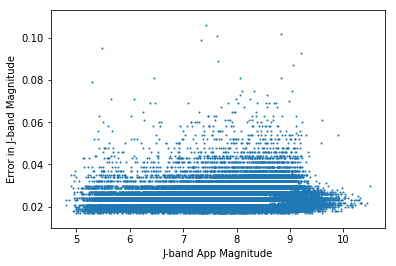

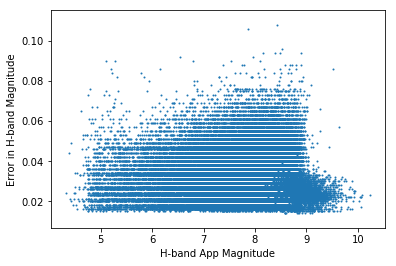

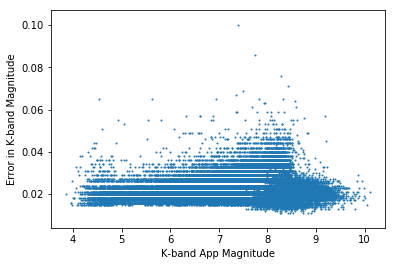

In [435]:
plt.xlabel("J-band App Magnitude")
plt.ylabel("K-band App Magnitude")
plt.scatter(Jmags,Kmags,s=1.0)
plt.show()
plt.xlabel("J-band App Magnitude")
plt.ylabel("H-band App Magnitude")
plt.scatter(Jmags,Hmags,s=1.0)
plt.show()
JmH = Jmags-Hmags
HmK = Hmags-Kmags
# plt.xlim(-1.,1.)
# plt.ylim(-1.,1.)
plt.xlabel("J-H Magnitude")
plt.ylabel("H-K Magnitude")
plt.scatter(JmH,HmK,s=1.0)
plt.show()
eJmags = t1["e_Jmag"]
eHmags = t1["e_Hmag"]
eKmags = t1["e_Kmag"]
plt.xlabel("J-band App Magnitude")
plt.ylabel("Error in J-band Magnitude")
plt.scatter(Jmags,eJmags,s=1.0)
plt.show()
plt.xlabel("H-band App Magnitude")
plt.ylabel("Error in H-band Magnitude")
plt.scatter(Hmags,eHmags,s=1.0)
plt.show()
plt.xlabel("K-band App Magnitude")
plt.ylabel("Error in K-band Magnitude")
plt.scatter(Kmags,eKmags,s=1.0)
plt.show()

Luminosity Class is often but not always given in the Wright et al Spectral Type column. The placement of the luminosity class within the spectral type is not consistent and sometimes there is more than one class (III/IV for example). There are also some that are designated as binaries with 2 spectral types given, generally with a "+" sign between then. The code below tried to deal with this by translative the ascii into a number representation for the class.
V becomes 5.0; III becomes 3.0; IV/V =4.5, etc. If there is no luminosity class given, I assigned 5.1 (assuming that it probably is V but so we can tell the difference from a real V).
Binary stars and stars with funky lumonsity/spectral designations are assigned a negative number.

In [436]:
#  Translate Spectra Type luminosity class into a number from 1 to 5
#     or a negative number if it is a binary or unknown spectral type.
#     Note that many stars do not have a luminosity class. There are given 5.1.
#
SpType = t1["SpType"]
SpTypeN = [0.0]*len(SpType)
for i in range(0,len(SpType)):
    if(SpType.mask[i] == False):
        SpT = SpType[i].decode()
        if(len(SpT) > 2):
            for j in range(0,len(SpT)):
                if(SpT[j] == 'I'):
                    SpTypeN[i] = SpTypeN[i] + 1
                if(SpT[j] == 'V'):
                    SpTypeN[i] = SpTypeN[i] + 5
                if(SpT[j] == '+'):
                    SpTypeN[i] = -20.
                
        else:
            SpTypeN[i] = 5.1
        
        if(SpTypeN[i] == 6):
            SpTypeN[i] = 4.
        if(SpTypeN[i] == 11):
            SpTypeN[i] = 4.5
        if(SpTypeN[i] == 9):
            SpTypeN[i] = 3.5
        if(SpTypeN[i] > 5.2):
            SpTypeN[i] = -30.
print("Finished Luminosity Class Translation")
count = 0
for i in range(0,len(SpType)):
    if(SpTypeN[i] < 0.):
        count = count + 1
test = SpType.compressed()
good = len(test) - count
print("  Number of single Stars: ",good,"  Binaries or Unknown luminosity class: ",count)


Finished Luminosity Class Translation
  Number of single Stars:  49535   Binaries or Unknown luminosity class:  423


In [389]:
print(SpTypeN[0:30])

[4.0, 5.1, 5.1, 5.0, 5.0, 3.0, 5.1, 3.0, 5.0, 5.1, 4.0, 5.1, 5.1, 5.1, 5.1, 3.0, 5.1, 0.0, 5.1, 5.1, 0.0, 5.1, 5.1, 0.0, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1]


/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


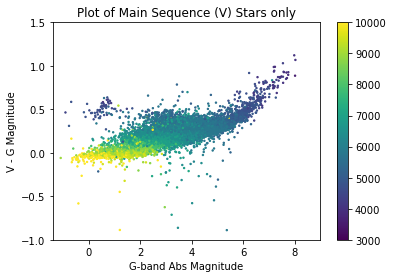

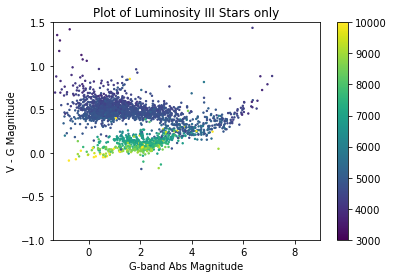

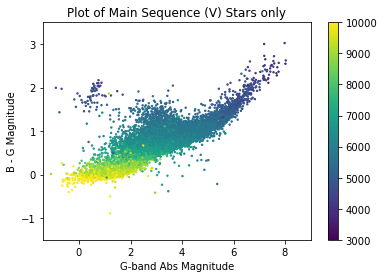

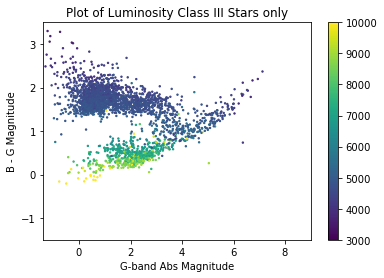

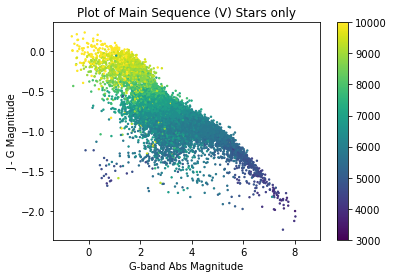

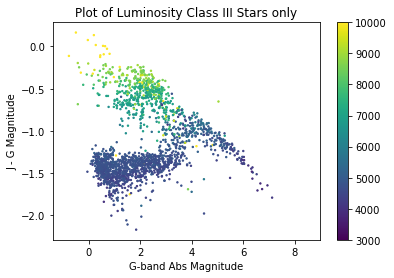

In [407]:
Dist = 1000./t1["Plx"]
Vmags = t1['VTmag'] + 5 - 5*np.log10(Dist)
Bmags = t1['BTmag'] + 5 - 5*np.log10(Dist)
Gmags = t1['__Gmag_'] + 5 - 5*np.log10(Dist)
Jmags = t1['Jmag'] + 5 - 5 * np.log10(Dist)
Hmags = t1['Hmag'] + 5 - 5 * np.log10(Dist)
Kmags = t1['Kmag'] + 5 - 5 * np.log10(Dist)
Teff = t1["Teff"]
VmG = Vmags - Gmags
BmG = Bmags - Gmags
JmG = Jmags - Gmags
for i in range(0,len(VmG)):
    if(SpTypeN[i] > 4.9 and SpTypeN[i] < 5.05):
        VmG.mask[i] = False
    else:
        VmG.mask[i] = True
plt.xlim(-1.4,9)
plt.ylim(-1.0,1.5)
plt.title("Plot of Main Sequence (V) Stars only")
plt.xlabel("G-band Abs Magnitude")
plt.ylabel("V - G Magnitude")
plt.scatter(Gmags,VmG,s=2.0,c=Teff,vmin=3000,vmax=10000)
plt.colorbar()
plt.show()
for i in range(0,len(VmG)):
    if(SpTypeN[i] > 2.9 and SpTypeN[i] < 3.1):
        VmG.mask[i] = False
    else:
        VmG.mask[i] = True
plt.xlim(-1.4,9)
plt.ylim(-1.0,1.5)
plt.title("Plot of Luminosity III Stars only")
plt.xlabel("G-band Abs Magnitude")
plt.ylabel("V - G Magnitude")
plt.scatter(Gmags,VmG,s=2.0,c=Teff,vmin=3000,vmax=10000)
plt.colorbar()
plt.show()
for i in range(0,len(VmG)):
    if(SpTypeN[i] > 4.9 and SpTypeN[i] < 5.05):
        BmG.mask[i] = False
    else:
        BmG.mask[i] = True
plt.title("Plot of Main Sequence (V) Stars only")
plt.xlabel("G-band Abs Magnitude")
plt.ylabel("B - G Magnitude")
plt.xlim(-1.4,9.)
plt.ylim(-1.5,3.5)
plt.scatter(Gmags,BmG,s=2.0,c=Teff,vmin=3000,vmax=10000)
plt.colorbar()
plt.show()
for i in range(0,len(VmG)):
    if(SpTypeN[i] > 2.9 and SpTypeN[i] < 3.1):
        BmG.mask[i] = False
    else:
        BmG.mask[i] = True
plt.title("Plot of Luminosity Class III Stars only")
plt.xlabel("G-band Abs Magnitude")
plt.ylabel("B - G Magnitude")
plt.xlim(-1.4,9.)
plt.ylim(-1.5,3.5)
plt.scatter(Gmags,BmG,s=2.0,c=Teff,vmin=3000,vmax=10000)
plt.colorbar()
plt.show()

for i in range(0,len(JmG)):
    if(SpTypeN[i] > 4.9 and SpTypeN[i] < 5.05):
        JmG.mask[i] = False
        if(Jmags.mask[i] == True):
            JmG.mask[i] = True
    else:
        JmG.mask[i] = True
plt.title("Plot of Main Sequence (V) Stars only")
plt.xlabel("G-band Abs Magnitude")
plt.ylabel("J - G Magnitude")
plt.xlim(-1.4,9.)
#plt.ylim(-1.0,3.0)
plt.scatter(Gmags,JmG,s=2.0,c=Teff,vmin=3000,vmax=10000)
plt.colorbar()
plt.show()
for i in range(0,len(JmG)):
    if(SpTypeN[i] > 2.9 and SpTypeN[i] < 3.1):
        JmG.mask[i] = False
        if(Jmags.mask[i] == True):
            JmG.mask[i] = True
    else:
        JmG.mask[i] = True
plt.title("Plot of Luminosity Class III Stars only")
plt.xlabel("G-band Abs Magnitude")
plt.ylabel("J - G Magnitude")
plt.xlim(-1.4,9.)
#plt.ylim(-1.0,3.0)
plt.scatter(Gmags,JmG,s=2.0,c=Teff,vmin=3000,vmax=10000)
plt.colorbar()
plt.show()

[3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]


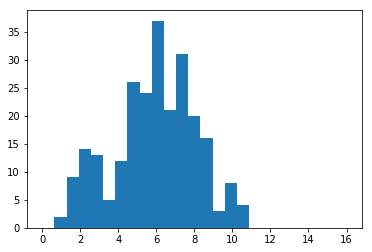

Number of stars in Teff= 3500 - 3999 : 245
     Median value:  5.90786
     Variance:      2.17816


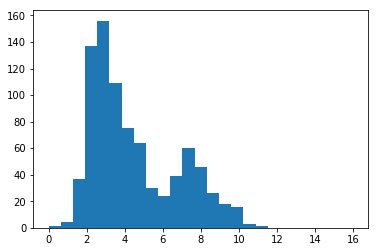

Number of stars in Teff= 4000 - 4499 : 846
     Median value:  4.48732
     Variance:      2.2741


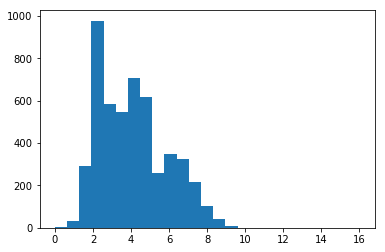

Number of stars in Teff= 4500 - 4999 : 5069
     Median value:  4.10804
     Variance:      1.77179


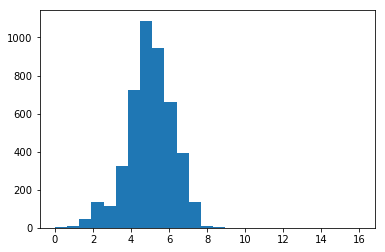

Number of stars in Teff= 5000 - 5499 : 4594
     Median value:  5.01261
     Variance:      1.18131


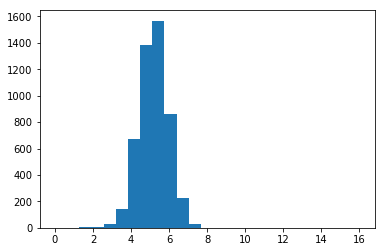

Number of stars in Teff= 5500 - 5999 : 4938
     Median value:  5.18874
     Variance:      0.768024


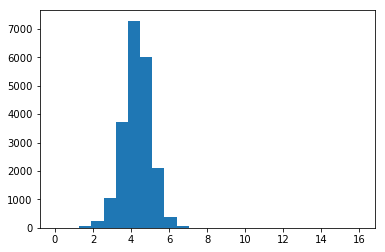

Number of stars in Teff= 6000 - 6499 : 20920
     Median value:  4.30758
     Variance:      0.728576


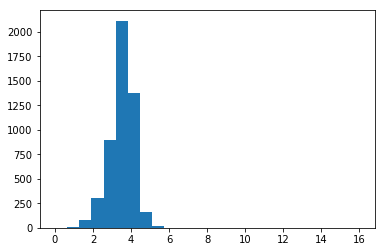

Number of stars in Teff= 6500 - 6999 : 4958
     Median value:  3.51561
     Variance:      0.624585


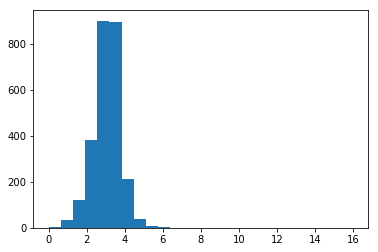

Number of stars in Teff= 7000 - 7499 : 2603
     Median value:  3.06344
     Variance:      0.711879


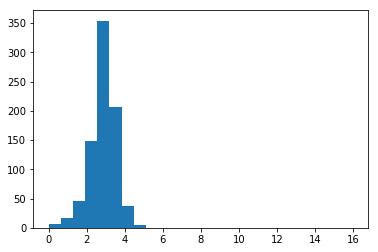

Number of stars in Teff= 7500 - 7999 : 820
     Median value:  2.86324
     Variance:      0.687928


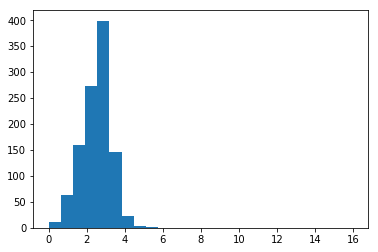

Number of stars in Teff= 8000 - 8499 : 1083
     Median value:  2.50572
     Variance:      0.775549


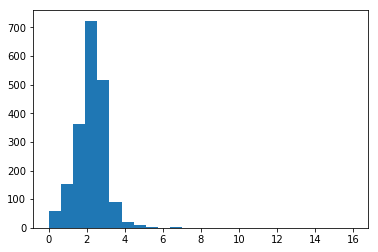

Number of stars in Teff= 8500 - 8999 : 1945
     Median value:  2.21779
     Variance:      0.77511


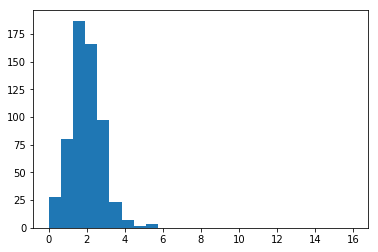

Number of stars in Teff= 9000 - 9499 : 597
     Median value:  1.96614
     Variance:      0.814747


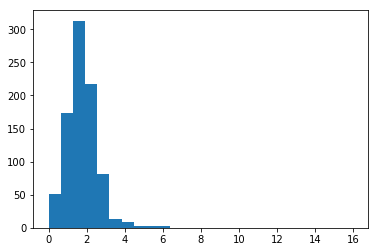

Number of stars in Teff= 9500 - 9999 : 875
     Median value:  1.74205
     Variance:      0.806088


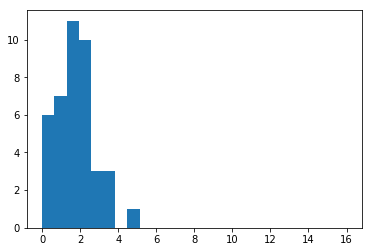

Number of stars in Teff= 10000 - 10499 : 43
     Median value:  1.67719
     Variance:      1.05244


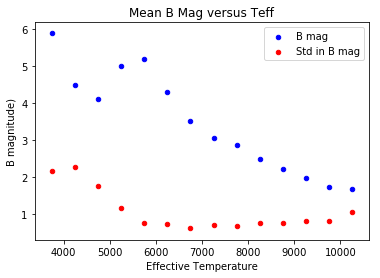

In [391]:
Teff = t1["Teff"]

temps = [3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000]
print(temps)
Tave = []
Bmean = []
Bstd = []

for tlow in temps:
    thi = tlow + 499.
    tmean = (thi+tlow)/2.0
    TeffMask = ma.masked_outside(Teff,tlow,thi)
    BMask = ma.array(Bmags,mask=TeffMask.mask)
    Bplt = ma.compressed(BMask)
    plt.hist(Bplt,bins=25,range=(0,16))
    plt.show()
    Tave.append(tmean)
    Bmean.append(np.mean(Bplt))
    Bstd.append(np.std(Bplt))
    print("Number of stars in Teff= %g - %g :"%(tlow,thi), TeffMask.count())
    print("     Median value: ", np.mean(Bplt))
    print("     Variance:     ",np.std(Bplt))

plt.title("Mean B Mag versus Teff")
plt.xlabel('Effective Temperature')
plt.ylabel('B magnitude)')
pllab1 = plt.scatter(Tave,Bmean,s=20,c='b', label='plt1')
pllab2 = plt.scatter(Tave,Bstd,s=20,c='r', label='plt2')
plt.legend([pllab1,pllab2],['B mag','Std in B mag'])
plt.show()

In [48]:
eGflux = t1["e__FG_"]
Gflux = t1["__FG_"]
Gmags = t1["__Gmag_"]
for i in range(0,len(Gflux)):
    SNR = Gflux[i]/eGflux[i]
    if(SNR < 20):
        print(Gflux[i],eGflux[i],SNR, Gmags[i])
print("Finished testing G-band SNR")

4715350.45069 297926.3987 15.8272327369 8.841
470609.26764 38319.77203 12.2811082298 11.343
9454890.22577 871081.47488 10.8541973379 8.086
620078.72445 40360.92696 15.3633420031 11.044
16644155.3597 1417120.64402 11.7450517921 7.472
11712494.7108 874715.62735 13.3900599744 7.853
77333.06189 12615.8944 6.12981207975 13.304
4230130.34385 279291.46995 15.1459346202 8.959
4411172.55434 230246.49579 19.1584785654 8.913
13770167.194 876170.21459 15.7163151231 7.677
52812834.1968 3399307.1187 15.5363526603 6.218
16753852.9399 1791108.42674 9.35390213666 7.464
19073235.7548 958879.2069 19.8911767171 7.324
5539576.347 296924.21656 18.6565326708 8.666
Finished testing G-band SNR


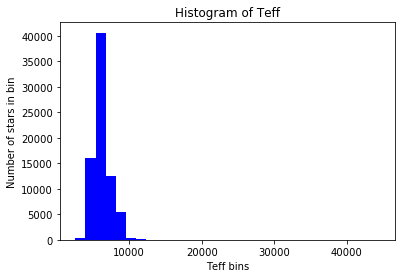

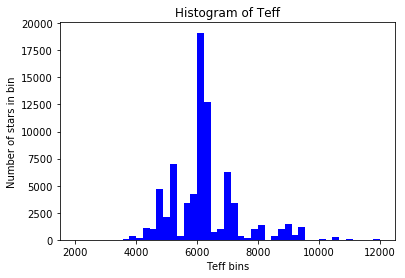

Results of number of stars in low Teff bins for TGAS x Wright et al Catalog
   Number of stars between 2000 and 2500:  0
   Number of stars between 2501 and 3000:  11
   Number of stars between 3001 and 3500:  5
   Number of stars between 3500 and 4000:  269
   Number of stars between 4001 and 4500:  822


In [392]:
plt.title("Histogram of Teff")
plt.xlabel('Teff bins')
plt.ylabel('Number of stars in bin')
plt.hist(Teff,bins=30,color='b')
plt.show()

plt.title("Histogram of Teff")
plt.xlabel('Teff bins')
plt.ylabel('Number of stars in bin')
plt.hist(Teff,bins=45,range=(2000,12000),color='b')
plt.show()

print("Results of number of stars in low Teff bins for TGAS x Wright et al Catalog")
TeffMask = ma.masked_outside(Teff,2000,2500)
print("   Number of stars between 2000 and 2500: ", TeffMask.count())
TeffMask = ma.masked_outside(Teff,2501,3000)
print("   Number of stars between 2501 and 3000: ", TeffMask.count())
TeffMask = ma.masked_outside(Teff,3001,3500)
print("   Number of stars between 3001 and 3500: ", TeffMask.count())
TeffMask = ma.masked_outside(Teff,3501,4000)
print("   Number of stars between 3500 and 4000: ", TeffMask.count())
TeffMask = ma.masked_outside(Teff,4001,4500)
print("   Number of stars between 4001 and 4500: ", TeffMask.count())

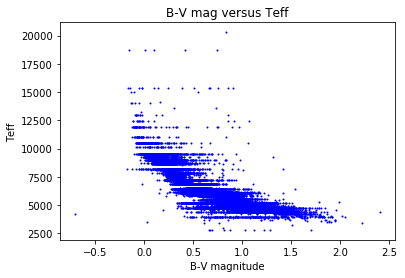

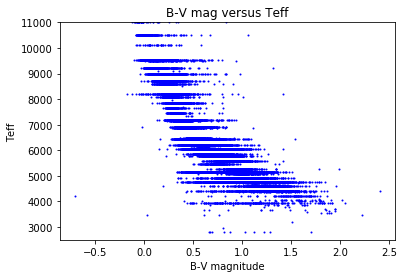

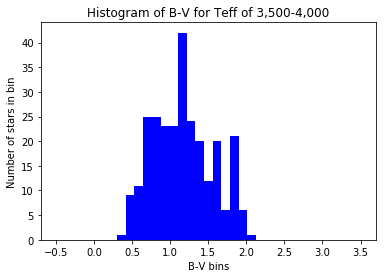

Number of stars in Teff=3,500-4,000: 269
     Median value:  1.16636
     Variance:      0.388577


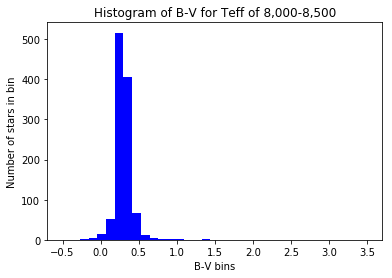

Number of stars in Teff=8,000-8,500: 1083
     Median value:  0.296482
     Variance:      0.107266
[2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000]
Number of stars in Teff= 2500 - 2999 : 11
     Median value:  0.988545
     Variance:      0.308644
Number of stars in Teff= 3000 - 3499 : 5
     Median value:  1.03
     Variance:      0.76259
Number of stars in Teff= 3500 - 3999 : 245
     Median value:  1.1354
     Variance:      0.376208
Number of stars in Teff= 4000 - 4499 : 846
     Median value:  1.2973
     Variance:      0.270348
Number of stars in Teff= 4500 - 4999 : 5069
     Median value:  1.09737
     Variance:      0.206541
Number of stars in Teff= 5000 - 5499 : 4594
     Median value:  0.810768
     Variance:      0.180071
Number of stars in Teff= 5500 - 5999 : 4938
     Median value:  0.74984
     Variance:      0.106318
Number of stars in Teff= 6000 - 6499 : 20920
     Median value:  0.583859
    

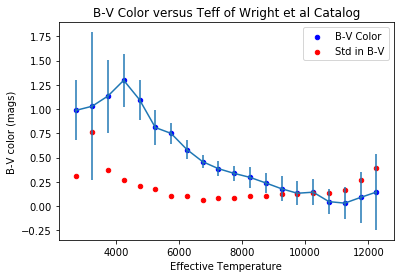

In [393]:
BmV = Bmags - Vmags
plt.title("B-V mag versus Teff")
plt.xlabel('B-V magnitude')
plt.ylabel('Teff')
plt.scatter(BmV,Teff,color='b',s=1.0)
plt.show()

plt.title("B-V mag versus Teff")
plt.xlabel('B-V magnitude')
plt.ylabel('Teff')
plt.ylim(2500,11000)
plt.scatter(BmV,Teff,color='b',s=1.0)
plt.show()

TeffMask = ma.masked_outside(Teff,3500,4000)
BmVMask = ma.array(BmV,mask=TeffMask.mask)
BmVplt = BmVMask.compressed()
plt.title("Histogram of B-V for Teff of 3,500-4,000")
plt.xlabel('B-V bins')
plt.ylabel('Number of stars in bin')
plt.hist(BmVplt,bins=35,range=(-0.5,3.5),color='b')
plt.show()
print("Number of stars in Teff=3,500-4,000:", TeffMask.count())
print("     Median value: ", np.mean(BmVplt))
print("     Variance:     ",np.std(BmVplt))

TeffMask = ma.masked_outside(Teff,8000,8500)
BmVMask = ma.array(BmV,mask=TeffMask.mask)
BmVplt = BmVMask.compressed()
plt.title("Histogram of B-V for Teff of 8,000-8,500")
plt.xlabel('B-V bins')
plt.ylabel('Number of stars in bin')
plt.hist(BmVplt,bins=35,range=(-0.5,3.5),color='b')
plt.show()
print("Number of stars in Teff=8,000-8,500:", TeffMask.count())
print("     Median value: ", np.mean(BmVplt))
print("     Variance:     ",np.std(BmVplt))

temps = [2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000,10500,11000,11500,12000]
print(temps)
Tave = []
BmVave = []
BmVstd = []
for tlow in temps:
    thi = tlow + 499.
    tmean = (thi+tlow)/2.0
    TeffMask = ma.masked_outside(Teff,tlow,thi)
    BmVMask = ma.array(BmV,mask=TeffMask.mask)
    BmVplt = BmVMask.compressed()
    Tave.append(tmean)
    BmVave.append(np.mean(BmVplt))
    BmVstd.append(np.std(BmVplt))
    print("Number of stars in Teff= %g - %g :"%(tlow,thi), TeffMask.count())
    print("     Median value: ", np.mean(BmVplt))
    print("     Variance:     ",np.std(BmVplt))
print(Tave)
print(BmVave)

plt.title("B-V Color versus Teff of Wright et al Catalog")
plt.xlabel('Effective Temperature')
plt.ylabel('B-V color (mags)')
pllab1 = plt.scatter(Tave,BmVave,s=20,c='b', label='plt1')
pllab2 = plt.scatter(Tave,BmVstd,s=20,c='r', label='plt2')
plt.legend([pllab1,pllab2],['B-V Color','Std in B-V'])
plt.errorbar(Tave,BmVave,yerr=BmVstd)
plt.show()


In [394]:
BmG = Bmags - Gmags
VmG = Vmags - Gmags
JmG = Jmags - Gmags
HmG = Hmags - Gmags
KmG = Kmags - Gmags
Tsed = np.zeros((len(temps),5))
Tsed_std = np.zeros((len(temps),5))
Tsed_cnt = np.zeros((len(temps),5))
Temp_SED = np.zeros(len(temps))
for i in range(0,len(temps)):
    tlo = temps[i]-0.1
    thi = tlo + 500.
    Temp_SED[i] = (thi+tlo)/2.0
    TeffMask = ma.masked_outside(Teff,tlo,thi)
    BmGMask = ma.array(BmG,mask=TeffMask.mask)
    Tsed[i,0] = np.mean(BmGMask)
    Tsed_std[i,0] = np.std(BmGMask)
    Tsed_cnt[i,0] = TeffMask.count()
    print(" B-G: Teff range: %g to %g"%(tlo,thi)," Mean: ",np.mean(BmGMask),"variance: ",np.std(BmGMask))
    VmGMask = ma.array(VmG,mask=TeffMask.mask)
    Tsed[i,1] = np.mean(VmGMask)
    Tsed_std[i,1] = np.std(VmGMask)
    Tsed_cnt[i,1] = TeffMask.count()
    print(" V-G: Teff range: %g to %g"%(tlo,thi)," Mean: ",np.mean(VmGMask),"variance: ",np.std(VmGMask))
    JmGMask = ma.array(JmG,mask=TeffMask.mask)
    Tsed[i,2] = np.mean(JmGMask)
    Tsed_std[i,2] = np.std(JmGMask)
    Tsed_cnt[i,2] = TeffMask.count()
    print(" J-G: Teff range: %g to %g"%(tlo,thi)," Mean: ",np.mean(JmGMask),"variance: ",np.std(JmGMask))
    HmGMask = ma.array(HmG,mask=TeffMask.mask)
    Tsed[i,3] = np.mean(HmGMask)
    Tsed_std[i,3] = np.std(HmGMask)
    Tsed_cnt[i,3] = TeffMask.count()
    print(" H-G: Teff range: %g to %g"%(tlo,thi)," Mean: ",np.mean(HmGMask),"variance: ",np.std(HmGMask))
    KmGMask = ma.array(KmG,mask=TeffMask.mask)
    Tsed[i,4] = np.mean(KmGMask)
    Tsed_std[i,4] = np.std(KmGMask)
    Tsed_cnt[i,4] = TeffMask.count()
    print(" K-G: Teff range: %g to %g"%(tlo,thi)," Mean: ",np.mean(KmGMask),"variance: ",np.std(KmGMask))

 B-G: Teff range: 2499.9 to 2999.9  Mean:  1.41645457528 variance:  0.504800272104
 V-G: Teff range: 2499.9 to 2999.9  Mean:  0.427909027446 variance:  0.201571466588
 J-G: Teff range: 2499.9 to 2999.9  Mean:  -1.30645457181 variance:  0.374591121885
 H-G: Teff range: 2499.9 to 2999.9  Mean:  -1.73609109358 variance:  0.517205803794
 K-G: Teff range: 2499.9 to 2999.9  Mean:  -1.77030029297 variance:  0.523498567189
 B-G: Teff range: 2999.9 to 3499.9  Mean:  1.65540008545 variance:  1.32904102023
 V-G: Teff range: 2999.9 to 3499.9  Mean:  0.625399971008 variance:  0.579094801726
 J-G: Teff range: 2999.9 to 3499.9  Mean:  -0.940249681473 variance:  0.564986043328
 H-G: Teff range: 2999.9 to 3499.9  Mean:  -1.21599984169 variance:  0.786106761392
 K-G: Teff range: 2999.9 to 3499.9  Mean:  -1.32149982452 variance:  0.850991732162
 B-G: Teff range: 3499.9 to 3999.9  Mean:  1.63773068798 variance:  0.589704048754
 V-G: Teff range: 3499.9 to 3999.9  Mean:  0.502334688148 variance:  0.24758466

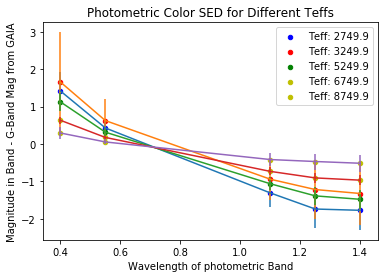

In [395]:
SEDplt = Tsed[0, : ]
SEDstd = Tsed_std[0, : ]
SEDtmp = Temp_SED[0]
SEDwave = np.array([.4,.55,1.1,1.25,1.4])
plt.title("Photometric Color SED for Different Teffs")
plt.xlabel('Wavelength of photometric Band')
plt.ylabel('Magnitude in Band - G-Band Mag from GAIA')
pllab1 = plt.scatter(SEDwave,SEDplt,s=20,c='b', label='plt1')
plt.errorbar(SEDwave,SEDplt,yerr=SEDstd)

SEDplt = Tsed[1, : ]
SEDstd = Tsed_std[1, : ]
SEDtmp = Temp_SED[1]
pllab2 = plt.scatter(SEDwave,SEDplt,s=20,c='r', label='plt2')
plt.errorbar(SEDwave,SEDplt,yerr=SEDstd)

SEDplt = Tsed[5, : ]
SEDstd = Tsed_std[5, : ]
SEDtmp = Temp_SED[5]
pllab3 = plt.scatter(SEDwave,SEDplt,s=20,c='g', label='plt3')
plt.errorbar(SEDwave,SEDplt,yerr=SEDstd)

SEDplt = Tsed[8, : ]
SEDstd = Tsed_std[8, : ]
SEDtmp = Temp_SED[8]
pllab4 = plt.scatter(SEDwave,SEDplt,s=20,c='y', label='plt4')
plt.errorbar(SEDwave,SEDplt,yerr=SEDstd)

SEDplt = Tsed[12, : ]
SEDstd = Tsed_std[12, : ]
SEDtmp = Temp_SED[12]
pllab5 = plt.scatter(SEDwave,SEDplt,s=20,c='y', label='plt5')
plt.errorbar(SEDwave,SEDplt,yerr=SEDstd)

plt.legend([pllab1,pllab2,pllab3,pllab4,pllab5],['Teff: %g'%(Temp_SED[0]),'Teff: %g'%(Temp_SED[1]),'Teff: %g'%(Temp_SED[5]),'Teff: %g'%(Temp_SED[8]),'Teff: %g'%(Temp_SED[12])])
plt.show()


In [405]:
chi2 = np.zeros(len(Temp_SED))
i = 31105
Test_SED = np.array([Bmags[i]-Gmags[i],Vmags[i]-Gmags[i],Jmags[i]-Gmags[i],Hmags[i]-Gmags[i],Kmags[i]-Gmags[i]])
print(Test_SED)
for j in range(0,len(Temp_SED)):
    Template = Tsed[j, : ]
    for k in range(0,5):
        chi2[j] = chi2[j] + (Test_SED[k]-Template[k])*(Test_SED[k]-Template[k])/(0.1*0.1)/5
    print(Temp_SED[j],chi2[j])
print(Teff[i])

[ 1.04500008  0.29899979 -1.05000019 -1.3550005  -1.45199966]
2749.9 9.33820441327
3249.9 10.5504363209
3749.9 15.2730745118
4249.9 31.3327462904
4749.9 11.8891077018
5249.9 0.167135661623
5749.9 0.112445351541
6249.9 4.90169860277
6749.9 14.5000755189
7249.9 24.130514703
7749.9 31.6986639082
8249.9 41.774870482
8749.9 53.8883481013
9249.9 66.9896356474
9749.9 78.1619825049
10249.9 71.551689437
10749.9 98.0476398152
11249.9 99.0046589209
11749.9 86.3843538434
12249.9 70.6777498041
5860


In [472]:
count = 0
Temp_est = np.array([])
for i in range(0,len(Source)):
    if(Source.mask[i] == False):
        if((Jmags.mask[i] == False) and (Kmags.mask[i] == False)):
            if(Teff[i] > 5000 and Teff[i] < 5500.):
                chi2 = np.zeros(len(Temp_SED))
                Test_SED = np.array([Bmags[i]-Gmags[i],Vmags[i]-Gmags[i],Jmags[i]-Gmags[i],Hmags[i]-Gmags[i],Kmags[i]-Gmags[i]])
                for j in range(0,len(Temp_SED)):
                    Template = Tsed[j, : ]
                    for k in range(0,5):
                        chi2[j] = chi2[j] + (Test_SED[k]-Template[k])*(Test_SED[k]-Template[k])/(0.1*0.1)/5
                min_chi = np.where(chi2 == chi2.min()) 
                j = min_chi[0]
                print(j)
                np.append(Temp_est,[Temp_SED[j]])
                print(Temp_est[count])
                count = count + 1
print(len(Temp_est))
print(Temp_est[0:20])
plt.hist(Temp_est,bins=30)
plt.show()

[15]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [444]:
x = np.array([4,3,2,1,2,3,4,5])
ii = np.where(x == x.min())
print(ii)

(array([3]),)
